https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8      
https://medium.com/mlreview/multi-modal-methods-image-captioning-from-translation-to-attention-895b6444256e#660b       
https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import os
import random
from string import punctuation
from pickle import dump, load

In [0]:
import tensorflow
from tensorflow import keras

In [0]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.preprocessing.image import load_img, save_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu

## Captions

In [0]:
!unzip '/content/drive/My Drive/Images.zip'

In [0]:
img_names = os.listdir('/content/Images')
captions = open('Flickr8k.token.txt').read().split('\n')[:-1]

### Preprocess/Clean training captions 

In [10]:
df = {}
tokens = ['<s>','</s>']

for caption in captions:
    img_name, desc = caption.split()[0].split('.')[0], caption.split()[1:] 

    if img_name+'.jpg' not in img_names:
        continue
  
    if img_name not in df.keys():
        df[img_name] = list() 
    desc = [token.lower() for token in desc if token not in punctuation]
    tokens += desc
    df[img_name].append(['<s>']+desc+['</s>']) 

len(df)

8091

### Compute vocabulary

In [11]:
vocab = np.unique(tokens)
vocab_size = len(vocab)
le = LabelEncoder().fit(vocab)

vocab = pd.DataFrame({'word':vocab,'encoded':le.transform(vocab)})
vocab.head(3)

,word,encoded
0,'n',0
1,'s,1
2,'s-eye-view,2


### Learn Label Encoder from vocabulary

In [0]:
for key,captions in df.items():
    captions = [le.transform(caption) for caption in captions]
    df[key] = captions

### Generate Sequences from training captions

In [13]:
X1, X2, y = [],[],[]

for key in df.keys():
    captions = df[key]
    for caption in captions:
        for i in range(1,len(caption)):
            X1.append(key)
            X2.append(caption[:i])
            y.append(caption[i])

max_len = max([len(x) for x in X2])
X2 = pad_sequences(X2, value=-1, maxlen=max_len)    
X2 = [x for x in X2]
df = pd.DataFrame({'Image':X1,'Sequence':X2,'Output':y})
df.head()

,Image,Sequence,Output
0,1000268201_693b08cb0e,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",58
1,1000268201_693b08cb0e,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1474
2,1000268201_693b08cb0e,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",3906
3,1000268201_693b08cb0e,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",58
4,1000268201_693b08cb0e,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",5640


In [0]:
# df.to_csv('sequence_data.csv')
# files.download('sequence_data.csv') 

## Image Features

### Generate image feature vectors for all training images

In [0]:
def compute_features(model, image):
    
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = inception.predict(image, verbose=0)
    
    return feature

In [0]:
model = InceptionV3(weights='imagenet')
inception = Model(model.input, model.layers[-2].output)

# features = {}
# img_names = np.unique(df['Image'].values)

# for i, img in enumerate(img_names):
#     image = load_img('Images/'+img+'.jpg', target_size=(299, 299))
#     feature = compute_features(inception, img)

#     features[img] = feature

#     if i % 100 == 0: print(i)

# # dump(features, open('features.pkl', 'wb'))
# # files.download('features.pkl') 

In [41]:
features = load(open('features.pkl', 'rb'))
len(features)

8091

## Training

### Split data, both captions and image feature vectors into training and test

In [17]:
train_ind,test_ind = train_test_split(np.arange(len(features)),test_size=0.1,random_state=42)

imgs = list(features.keys())
train_imgs = [imgs[i] for i in train_ind]
test_imgs = [imgs[i] for i in test_ind]

print(len(train_imgs), len(test_imgs))

7281 810


In [18]:
train_df = pd.DataFrame({'Image':[],'Sequence':[],'Output':[]})
for img in train_imgs:
    train_df = train_df.append(df[df['Image']==img], ignore_index=True)

test_df = pd.DataFrame({'Image':[],'Sequence':[],'Output':[]})
for img in test_imgs:
    test_df = test_df.append(df[df['Image']==img], ignore_index=True)

train_df.shape, test_df.shape

((429363, 3), (47597, 3))

In [0]:
# Image features
inputs1 = Input(shape=(2048,))
dropout1 = Dropout(0.5)(inputs1)
dense = Dense(256, activation='relu')(dropout1)

# Captions
inputs2 = Input(shape=(max_len,))
embed = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
dropout2 = Dropout(0.5)(embed)
lstm = LSTM(256)(dropout2)

# Decoder 
decoder = add([dense, lstm])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

###### Data Generator

In [0]:
def data_generator(features, df):
    while 1:
        images = np.unique(df[:,0])

        for img in images:
            ind = np.where(df[:,0]==img)[0]

            im_features = np.array([features[im].reshape((features[im].size,)) for im in df[ind,0]])
            seq = np.array([s for s in df[ind,1]])
            outputs = to_categorical(np.array([o for o in df[ind,2]]), num_classes=vocab_size)

            yield [[im_features, seq], outputs]

#### Train model

In [0]:
epochs = 30
steps = len(train_imgs)

for i in range(epochs):
    print(i)
    input_generator = data_generator(features, train_df.values)

    model.fit_generator(generator=input_generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [0]:
# files.download('model_28.h5')

# Testing

## Evaluate

In [0]:
# model = keras.models.load_model('model.h5')
# model.summary()

### Generate Caption using Greedy Search

In [0]:
def generate_caption(model, feature, max_length):
    caption = ['<s>']

    for i in range(max_len):
        sequence = [vocab[vocab['word']==word]['encoded'].values[0] for word in caption]  
        sequence = pad_sequences([sequence], value=-1, maxlen=max_len)

        pred = model.predict([feature,sequence], verbose=0)
        pred = np.argmax(pred)
        word = vocab[vocab['encoded']==pred]['word'].values[0]

        if word is None:
            break
        caption += [word]

        if word == '</s>':
            break

    return ' '.join(caption[1:-1])

### Generate Caption using Beam Search

In [0]:
def generate_caption_beam(model, feature, max_length, beam_width=2):
    caption = ['<s>']

    for i in range(max_len):
        sequence = [vocab[vocab['word']==word]['encoded'].values[0] for word in caption]  
        sequence = pad_sequences([sequence], value=-1, maxlen=max_len)

        prob = model.predict([feature,sequence], verbose=0)
        pred = np.argsort(prob)[0][-beam_width:]
        prob = [prob[0][p] for p in pred]

        next_word,next_word_prob = [],[]
        for j, ind in enumerate(pred):
            word = vocab[vocab['encoded']==ind]['word'].values[0]
            temp_caption = caption + [word]
            temp_sequence = [vocab[vocab['word']==word]['encoded'].values[0] for word in temp_caption]  
            temp_sequence = pad_sequences([temp_sequence], value=-1, maxlen=max_len)

            temp_prob = model.predict([feature,temp_sequence], verbose=0)
            temp_pred = np.argsort(temp_prob)[0][-1]
            next_word = [word, vocab[vocab['encoded']==temp_pred]['word'].values[0]]
            next_word_prob += [temp_prob[0][temp_pred]]
        prob = np.argmax([prob[i]*next_word_prob[i] for i in range(len(prob))])
        pred = pred[prob]

        word = vocab[vocab['encoded']==pred]['word'].values[0]

        if word is None:
            break
        caption += [word]

        if word == '</s>':
            break

    return ' '.join(caption[1:-1])

In [0]:
def evaluate_model(model, features, df, max_length):
    actual, predicted = list(), list()

    for im in np.unique(df['Image'].values):

        pred = generate_caption(model, features[im], max_length)
        predicted.append([pred])
        real = df[df['Image']==im]['Sequence'].values[-1]
        real = [vocab[vocab['encoded']==x]['word'].values[0] for x in real if x != -1]
        actual.append(' '.join(real[1:]))

    return actual, predicted

In [0]:
actual, predicted = evaluate_model(model, features, test_df, max_len)

In [85]:
actual[0], predicted[0]

('two men are ice fishing', ['a man in a red shirt is standing on a rock'])

In [82]:
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


## Predict

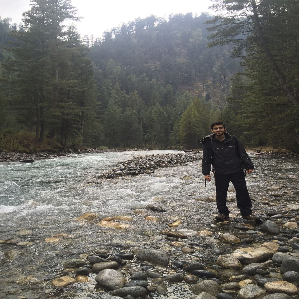

In [83]:
im = load_img('IMG_8659.JPEG', target_size=(299, 299))
im

In [68]:
f = compute_features(inception, im)
print(generate_caption(model, f, max_len))
print(generate_caption_beam(model, f, max_len))

a man in a blue shirt is standing on a rock overlooking the ocean
a man in a blue shirt is standing on top of a waterfall


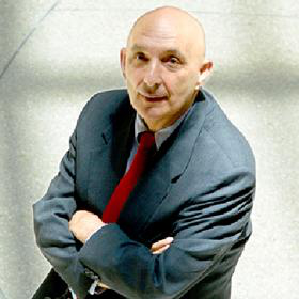

In [89]:
im = load_img('sos.jpg', target_size=(299, 299))
im

In [90]:
f = compute_features(inception, im)
print(generate_caption(model, f, max_len))
print(generate_caption_beam(model, f, max_len))

a man in a red shirt and a woman in a blue shirt are standing in front of a wooden structure
a man in a red shirt is sitting on a wooden bench with his shoes on


Original : the black and white dog runs through the field
Greedy Search : a black dog is running through the grass
Beam :  a black and white dog is running through the grass with a stick in its mouth


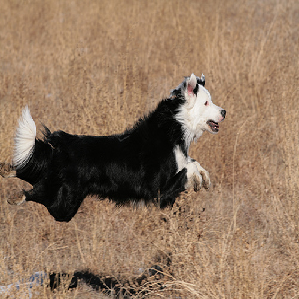

In [91]:
im = test_imgs[0]
f = features[im]
seq = test_df[test_df['Image']==im]['Sequence'].values[-1]
seq = ' '.join([vocab[vocab['encoded']==s]['word'].values[0] for s in seq if s != -1][1:])
print('Original :',seq)
print('Greedy Search :',generate_caption(model, f, max_len))
print('Beam : ',generate_caption_beam(model, f, max_len,beam_width=3))
load_img('Images/'+im+'.jpg', target_size=(299, 299))

Original : a young person wearing a helmet rides a unicycle
Greedy Search : a man in a red shirt is sitting on a campfire at night
Beam :  a man in a black shirt rides a bike down the street


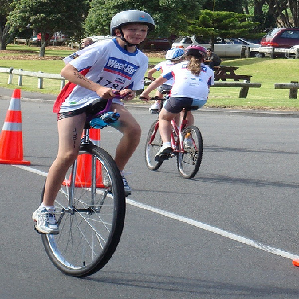

In [0]:
im = test_imgs[500]
f = features[im]
seq = test_df[test_df['Image']==im]['Sequence'].values[-1]
seq = ' '.join([vocab[vocab['encoded']==s]['word'].values[0] for s in seq if s != -1][1:])
print('Original :',seq)
print('Greedy Search :',generate_caption(model, f, max_len))
print('Beam : ',generate_caption_beam(model, f, max_len,beam_width=3))
load_img('Images/'+im+'.jpg', target_size=(299, 299))

Original : women walking down the street
Greedy Search : a man in a white shirt and jeans is standing on a sidewalk
Beam :  a young girl in a blue shirt is playing with a hula hoop on the sidewalk


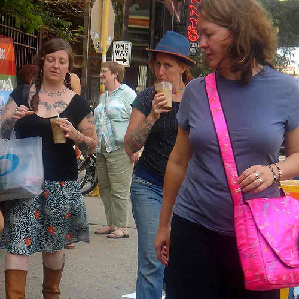

In [0]:
im = test_imgs[2]
f = features[im]
seq = test_df[test_df['Image']==im]['Sequence'].values[-1]
seq = ' '.join([vocab[vocab['encoded']==s]['word'].values[0] for s in seq if s != -1][1:])
print('Original :',seq)
print('Greedy Search :',generate_caption(model, f, max_len))
print('Beam : ',generate_caption_beam(model, f, max_len,beam_width=3))
load_img('Images/'+im+'.jpg', target_size=(299, 299))